In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import pad_sequences


In [ ]:
label = pd.read_csv('label.csv')

In [ ]:
import json
# Load tokenized sequences and config
with open('tokenized_sequences.json', 'r', encoding='utf-8') as f:
    tokenized_sequences = json.load(f)
with open('tokenizer_config.json', 'r', encoding='utf-8') as f:
    tokenizer_config = json.load(f)

In [ ]:
# Add padding to standarize the lenghts of tokenized data
from keras.preprocessing.sequence import pad_sequences
num_sequences = len(tokenized_sequences)
label1 = label[:num_sequences//5]
del label
max_sequence_length = max(len(seq) for seq in tokenized_sequences)
padded_sequences1 = pad_sequences(tokenized_sequences[:num_sequences//5], maxlen=max_sequence_length, padding='pre')
label1 = label1.astype('int8')
label1.value_counts()
del tokenized_sequences

In [ ]:
# Train, test, val split
X_train, X_test_temp, y_train, y_test_temp = train_test_split(padded_sequences1, label1, test_size=0.3, random_state=8, stratify=label1)
del padded_sequences1
X_val, X_test, y_val, y_test = train_test_split(X_test_temp, y_test_temp, test_size=0.4, random_state=8, stratify=y_test_temp)
del X_test_temp, y_test_temp

In [ ]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

model = Sequential([
    Embedding(input_dim=303354, output_dim=100, input_length=4714),
    Bidirectional(LSTM(21, kernel_initializer=glorot_uniform())),
    BatchNormalization(epsilon=1e-3),
    Dropout(0.4),
    Dense(29,activation='relu'),
    Dropout(0.2),
    Dense(13,activation='relu'),
    Dense(1,activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4714, 100)         30335400  
                                                                 
 bidirectional (Bidirection  (None, 42)                20496     
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 42)                168       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 29)                1247      
                                                                 
 dropout_1 (Dropout)         (None, 29)                0

In [ ]:
from tensorflow.keras.optimizers import Adam
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def data_generator(features, labels, batch_size=16):
    num_samples = len(features)
    while True:
        for batch_index in range(0, num_samples, batch_size):
            batch_features = features[batch_index:batch_index + batch_size]
            batch_labels = labels[batch_index:batch_index + batch_size]
            yield np.array(batch_features), np.array(batch_labels)

In [ ]:
# Set batch size
batch_size = 16
train_generator = data_generator(X_train, y_train, batch_size)
val_generator = data_generator(X_val, y_val, batch_size)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=1,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size
)

4263/4263 [==============================] - 1986s 462ms/step - loss: 0.1169 - accuracy: 0.9599 - val_loss: 0.0567 - val_accuracy: 0.9835


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Generate predictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_probs)

# Print metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


366/366 [==============================] - 67s 181ms/step
Test Loss: 0.0528
Test Accuracy: 98.40%
Precision: 0.9731
Recall: 0.9937
F1 Score: 0.9833
AUC: 0.9980


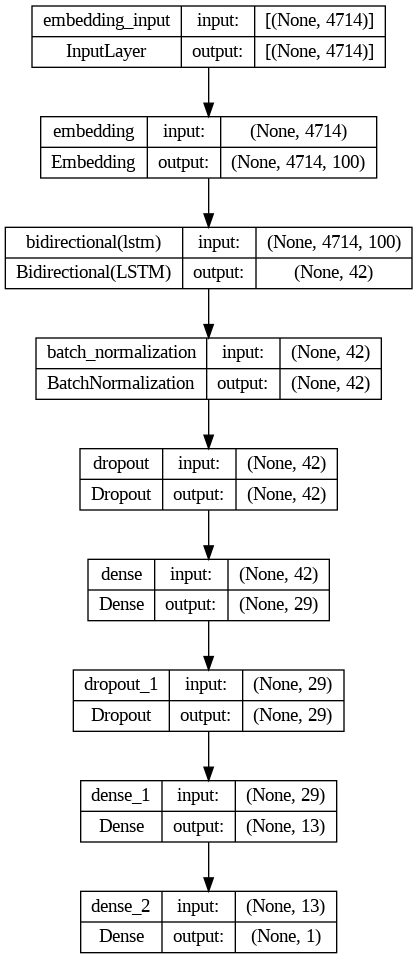

In [ ]:
# Plot the model
import keras
keras.utils.plot_model(model, to_file="out.png", show_shapes=True)